# Pokemon Classification

In this notebook we will explore classification supervised learning by classifying the types of different Pokemon based on their stats.

First we'll make sure the correct version of SciKit Learn is installed.

In [ ]:
!pip install --upgrade scikit-learn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


We import the necessary modules and set sklearn to display diagrams as output.

In [ ]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import balanced_accuracy_score, accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

sklearn.set_config(display='diagram')

## Data Exploration

We will be using a dataset containing Pokemon and their stats. See the references at the bottom of the notebook for the data source.

In [ ]:
data = pd.read_csv('pokemon_alopez247.csv', index_col='Number')
data

,Name,Type_1,Type_2,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,...,Color,hasGender,Pr_Male,Egg_Group_1,Egg_Group_2,hasMegaEvolution,Height_m,Weight_kg,Catch_Rate,Body_Style
Number,,,,,,,,,,,,,,,,,,,,,
1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,...,Green,True,0.875,Monster,Grass,False,0.71,6.9,45,quadruped
2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,...,Green,True,0.875,Monster,Grass,False,0.99,13.0,45,quadruped
3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,...,Green,True,0.875,Monster,Grass,True,2.01,100.0,45,quadruped
4,Charmander,Fire,NaN,309,39,52,43,60,50,65,...,Red,True,0.875,Monster,Dragon,False,0.61,8.5,45,bipedal_tailed
5,Charmeleon,Fire,NaN,405,58,64,58,80,65,80,...,Red,True,0.875,Monster,Dragon,False,1.09,19.0,45,bipedal_tailed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717,Yveltal,Dark,Flying,680,126,131,95,131,98,99,...,Red,False,NaN,Undiscovered,NaN,False,5.79,203.0,45,two_wings
718,Zygarde,Dragon,Ground,600,108,100,121,81,95,95,...,Green,False,NaN,Undiscovered,NaN,False,5.00,305.0,3,serpentine_body
719,Diancie,Rock,Fairy,600,50,100,150,100,150,50,...,Pink,False,NaN,Undiscovered,NaN,True,0.71,8.8,3,head_arms


Let's get some insight into our data.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 721 entries, 1 to 721
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              721 non-null    object 
 1   Type_1            721 non-null    object 
 2   Type_2            350 non-null    object 
 3   Total             721 non-null    int64  
 4   HP                721 non-null    int64  
 5   Attack            721 non-null    int64  
 6   Defense           721 non-null    int64  
 7   Sp_Atk            721 non-null    int64  
 8   Sp_Def            721 non-null    int64  
 9   Speed             721 non-null    int64  
 10  Generation        721 non-null    int64  
 11  isLegendary       721 non-null    bool   
 12  Color             721 non-null    object 
 13  hasGender         721 non-null    bool   
 14  Pr_Male           644 non-null    float64
 15  Egg_Group_1       721 non-null    object 
 16  Egg_Group_2       191 non-null    object 
 1

One important thing to note here is that `Type_1` has all non-null values, but `Type_2` only has 350 out of 721 non-null values.

Since we are classifying the type of each Pokemon, it's important to understand how much data of each type we have to work with. We can use `value_counts` to see how many Pokemon of each type we have.

In [ ]:
data['Type_1'].value_counts()

Water       105
Normal       93
Grass        66
Bug          63
Fire         47
Psychic      47
Rock         41
Electric     36
Ground       30
Poison       28
Dark         28
Fighting     25
Dragon       24
Ghost        23
Ice          23
Steel        22
Fairy        17
Flying        3
Name: Type_1, dtype: int64

For the primary type, there are a few types which we don't have many examples of. This will be problematic for classification of these types because our model will not have much to learn from!

Let's also look at the secondary type to see if we have more examples there.

In [ ]:
data['Type_2'].value_counts()

Flying      87
Poison      31
Ground      30
Psychic     27
Fighting    19
Steel       19
Fairy       18
Grass       18
Dark        16
Dragon      14
Rock        14
Water       13
Ghost       12
Ice         10
Fire         9
Electric     6
Normal       4
Bug          3
Name: Type_2, dtype: int64

That's a bit better, it should be more balanced if we use the secondary types as well.


## Binary Classification

We will start by classifying whether or not a Pokemon is a fire type.

In classification, the model typically needs to work with 0s and 1s instead of strings, so we encode the string values for each row. The encoding works by placing a 1 whenever the row is a positive example, and a 0 when it is not. So in this case, we want 1s whenever a Pokemon is a fire type, and 0s if it is any other type. Predicting 1s and 0s is why it's called *binary classification*.

We can achieve this with pandas using `pd.get_dummies`. This function will give us a column of 0s and 1s for each category (the types are the categories in this case). After we have those columns for each type, we just take the fire columns.



In [ ]:
dummies = pd.get_dummies(data, columns=['Type_1', 'Type_2'])[['Type_1_Fire', 'Type_2_Fire']]
dummies.head()

,Type_1_Fire,Type_2_Fire
Number,,
1,0,0
2,0,0
3,0,0
4,1,0
5,1,0


**Challenge**: Take a look at the output of just `pd.get_dummies(data)` and consider why each of the columns in the output is there, what values they will contain, and what each value means.

In [ ]:
pd.get_dummies(data)

,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,isLegendary,hasGender,...,Body_Style_head_base,Body_Style_head_legs,Body_Style_head_only,Body_Style_insectoid,Body_Style_multiple_bodies,Body_Style_quadruped,Body_Style_serpentine_body,Body_Style_several_limbs,Body_Style_two_wings,Body_Style_with_fins
Number,,,,,,,,,,,,,,,,,,,,,
1,318,45,49,49,65,65,45,1,False,True,...,0,0,0,0,0,1,0,0,0,0
2,405,60,62,63,80,80,60,1,False,True,...,0,0,0,0,0,1,0,0,0,0
3,525,80,82,83,100,100,80,1,False,True,...,0,0,0,0,0,1,0,0,0,0
4,309,39,52,43,60,50,65,1,False,True,...,0,0,0,0,0,0,0,0,0,0
5,405,58,64,58,80,65,80,1,False,True,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717,680,126,131,95,131,98,99,6,True,False,...,0,0,0,0,0,0,0,0,1,0
718,600,108,100,121,81,95,95,6,True,False,...,0,0,0,0,0,0,1,0,0,0
719,600,50,100,150,100,150,50,6,True,False,...,0,0,0,0,0,0,0,0,0,0


We want to use both the primary and secondary types of each Pokemon, so we will use the `|` (or) operator to create a combined column `Is_Fire` which will contain 1 when the Pokemon is a fire type in either the primary or secondary type columns (or both, but that's not the case with pokemon). The `|` operator will give 1 if either operand is 1, and 0 otherwise.

In [ ]:
data['Is_Fire'] = dummies['Type_1_Fire'] | dummies['Type_2_Fire'] # 0|0=0, 1|0=1, 0|1=1, 1|1=1
data['Is_Fire']

Number
1      0
2      0
3      0
4      1
5      1
      ..
717    0
718    0
719    0
720    0
721    1
Name: Is_Fire, Length: 721, dtype: uint8

Just to confirm, let's check the `Is_Fire` column for the primary and secondary fire types.

In [ ]:
data[dummies['Type_1_Fire'] == 1].head()

,Name,Type_1,Type_2,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,...,hasGender,Pr_Male,Egg_Group_1,Egg_Group_2,hasMegaEvolution,Height_m,Weight_kg,Catch_Rate,Body_Style,Is_Fire
Number,,,,,,,,,,,,,,,,,,,,,
4,Charmander,Fire,NaN,309,39,52,43,60,50,65,...,True,0.875,Monster,Dragon,False,0.61,8.5,45,bipedal_tailed,1
5,Charmeleon,Fire,NaN,405,58,64,58,80,65,80,...,True,0.875,Monster,Dragon,False,1.09,19.0,45,bipedal_tailed,1
6,Charizard,Fire,Flying,534,78,84,78,109,85,100,...,True,0.875,Monster,Dragon,True,1.70,90.5,45,bipedal_tailed,1
37,Vulpix,Fire,NaN,299,38,41,40,50,65,65,...,True,0.250,Field,NaN,False,0.61,9.9,190,quadruped,1
38,Ninetales,Fire,NaN,505,73,76,75,81,100,100,...,True,0.250,Field,NaN,False,1.09,19.9,75,quadruped,1


In [ ]:
data[dummies['Type_2_Fire'] == 1].head()

,Name,Type_1,Type_2,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,...,hasGender,Pr_Male,Egg_Group_1,Egg_Group_2,hasMegaEvolution,Height_m,Weight_kg,Catch_Rate,Body_Style,Is_Fire
Number,,,,,,,,,,,,,,,,,,,,,
228,Houndour,Dark,Fire,330,45,60,30,80,50,65,...,True,0.5,Field,NaN,False,0.61,10.8,120,quadruped,1
229,Houndoom,Dark,Fire,500,75,90,50,110,80,95,...,True,0.5,Field,NaN,True,1.40,35.0,45,quadruped,1
494,Victini,Psychic,Fire,600,100,100,100,100,100,100,...,False,NaN,Undiscovered,NaN,False,0.41,4.0,3,bipedal_tailless,1
607,Litwick,Ghost,Fire,275,50,30,55,65,55,20,...,True,0.5,Amorphous,NaN,False,0.30,3.1,190,head_base,1
608,Lampent,Ghost,Fire,370,60,40,60,95,60,55,...,True,0.5,Amorphous,NaN,False,0.61,13.0,90,head_arms,1


Now that we have our data encoded in 1s and 0s, one interesting thing we can do is to look at the correlation between other values and whether the pokemon is a fire type. We can do this using the `corr` method.

In [ ]:
data.corr()['Is_Fire'] * 100

<ipython-input-12-2ae0ed62e60f>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()['Is_Fire'] * 100


Total                 7.575376
HP                    0.495891
Attack                5.424924
Defense              -5.492068
Sp_Atk               18.079236
Sp_Def                1.913491
Speed                 9.143877
Generation            2.143608
isLegendary           7.266698
hasGender            -0.032579
Pr_Male              15.118609
hasMegaEvolution      0.905764
Height_m              0.387869
Weight_kg             1.935757
Catch_Rate          -10.448037
Is_Fire             100.000000
Name: Is_Fire, dtype: float64

This tells us that as special attack (`Sp_Atk`) increases, the chance of the pokemon being a fire type increases. The same goes for the probability of the pokemon being a male (`Pr_Male`). So fire types are more likely to have high special attacks and to be male.

It also tells us that fire types are likely to have lower defense, and they will be harder to catch on average.

These are interesting statistics for us to look at, but we shouldn't be using them in our classification. We should be building a model that can figure out these kinds of relationships on its own!

**Challenge**: Are there any columns that are unlikely to tell us whether or not a pokemon is a fire type? Explain your answer.

Next up let's transform our input data to numeric data so that our model can understand it. We use the following steps:

1. We'll use everything but the Pokemon name to predict its type.

2. We'll also make sure we don't have any NaN values in our dataset, because the classification model doesn't know how to handle those.

3. We transform all non-numeric columns into sets of numeric columns using `get_dummies`. Each dummy column represents whether or not a Pokemon falls into the category represented by that column.

4. For any True/False data, we transform that into 1/0 data so our model can understand it.

In [ ]:
def transform_to_numeric(df):
    d1 = df.drop(columns=['Name', 'Type_1', 'Type_2']).fillna(0)
    return pd.get_dummies(d1).replace({True: 1, False: 0})

numeric = transform_to_numeric(data)
numeric.head()

,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,isLegendary,hasGender,...,Body_Style_head_base,Body_Style_head_legs,Body_Style_head_only,Body_Style_insectoid,Body_Style_multiple_bodies,Body_Style_quadruped,Body_Style_serpentine_body,Body_Style_several_limbs,Body_Style_two_wings,Body_Style_with_fins
Number,,,,,,,,,,,,,,,,,,,,,
1,318,45,49,49,65,65,45,1,0,1,...,0,0,0,0,0,1,0,0,0,0
2,405,60,62,63,80,80,60,1,0,1,...,0,0,0,0,0,1,0,0,0,0
3,525,80,82,83,100,100,80,1,0,1,...,0,0,0,0,0,1,0,0,0,0
4,309,39,52,43,60,50,65,1,0,1,...,0,0,0,0,0,0,0,0,0,0
5,405,58,64,58,80,65,80,1,0,1,...,0,0,0,0,0,0,0,0,0,0


Now we separate our inputs and outputs: our inputs are everything but the output column.

In [ ]:
X = numeric.drop(columns='Is_Fire')
y = numeric['Is_Fire']

In [ ]:
X.head()

,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,isLegendary,hasGender,...,Body_Style_head_base,Body_Style_head_legs,Body_Style_head_only,Body_Style_insectoid,Body_Style_multiple_bodies,Body_Style_quadruped,Body_Style_serpentine_body,Body_Style_several_limbs,Body_Style_two_wings,Body_Style_with_fins
Number,,,,,,,,,,,,,,,,,,,,,
1,318,45,49,49,65,65,45,1,0,1,...,0,0,0,0,0,1,0,0,0,0
2,405,60,62,63,80,80,60,1,0,1,...,0,0,0,0,0,1,0,0,0,0
3,525,80,82,83,100,100,80,1,0,1,...,0,0,0,0,0,1,0,0,0,0
4,309,39,52,43,60,50,65,1,0,1,...,0,0,0,0,0,0,0,0,0,0
5,405,58,64,58,80,65,80,1,0,1,...,0,0,0,0,0,0,0,0,0,0


`y` now contains our model's output **classes**, which are 0 and 1 in this case.

Let's look at the number of samples we have for each class.

In [ ]:
y.value_counts()

0    665
1     56
Name: Is_Fire, dtype: int64

We have way more non-fire samples than fire samples, which means we have an **unbalanced dataset**. This is fairly common in classification problems, and we'll need to keep this in mind while we're training and evaluating our model. With an unbalanced dataset, our model can become biased towards the majority class (0, i.e not fire, in this case) as it sees far more samples of that class.

Now we'll move on to training our model, so as usual we start by splitting our data into train and test sets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
X_train.head()

,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,isLegendary,hasGender,...,Body_Style_head_base,Body_Style_head_legs,Body_Style_head_only,Body_Style_insectoid,Body_Style_multiple_bodies,Body_Style_quadruped,Body_Style_serpentine_body,Body_Style_several_limbs,Body_Style_two_wings,Body_Style_with_fins
Number,,,,,,,,,,,,,,,,,,,,,
304,330,50,70,100,40,40,30,3,0,1,...,0,0,0,0,0,1,0,0,0,0
390,309,44,58,44,58,44,61,4,0,1,...,0,0,0,0,0,0,0,0,0,0
101,480,60,50,70,80,80,140,1,0,0,...,0,0,1,0,0,0,0,0,0,0
251,600,100,100,100,100,100,100,2,0,0,...,0,0,0,0,0,0,0,0,0,0
4,309,39,52,43,60,50,65,1,0,1,...,0,0,0,0,0,0,0,0,0,0


We will use **logistic regression** to perform the classification. Additionally, because we have columns on different scales (like height and weight, for example), we must scale our data before giving it to the model.

We could do this manually using `StandardScaler`, but this is error prone. For example, we could apply the scaling to the training data, but forget to apply it to the testing data; in this case our test results would be meaningless, because the data which the model learned from is entirely different from the data it is being evaluated on.

To help avoid errors like this, sklearn has the `Pipeline` class. We use pipelines to specify the preprocessing and the model all in one object by adding each as a pipeline step. The `Pipeline` object then behaves in the same way as the model class (the last step), except it first applies preprocessing to the data before passing the data to the model.

For example, if we have a pipeline `p`, we can do `p.fit(X, y)` and `p.score(X_test, y_test)`, and both times the data will be preprocessed in the exact same way.

`make_pipeline` is an easy way to make a `Pipeline`.

Note: `LogisticRegressionCV` is a special version of logisitic regression which automatically finds the best *hyperparameters* for the model using *cross validation* (CV).

In [ ]:
clf = make_pipeline(StandardScaler(), LogisticRegressionCV(max_iter=1500))
clf

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregressioncv', LogisticRegressionCV(max_iter=1500))])

Because we set `display='diagram'` above, sklearn gives a nice visualization of our pipeline. We can also click on each box to get more information about it!

Our pipeline now behaves in the same way as `LogisiticRegressionCV`, so we can call `fit` to train our model.

In [ ]:
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregressioncv', LogisticRegressionCV(max_iter=1500))])

We can also call `score` to evaluate our model (and the same preprocessing will be applied to the test data as the train data).

In [ ]:
clf.score(X_test, y_test)

0.9586206896551724

For logistic regression, `score` gives us the average accuracy, so in other words what percentage of the samples we got right.

Depending on how `train_test_split` split up your data (it shuffles it randomly), you should see a score of around 90-96% accuracy.



We can also use `predict` on our pipeline to get predictions about each pokemon. Let's use that to find which Pokemon we got wrong.

In [ ]:
def get_incorrect_predictions(pred, y_test):
    result = pd.DataFrame({**data.loc[X_test.index, ['Name', 'Type_1', 'Type_2']], 'Prediction': pred, 'Actual': y_test})
    return result[result['Prediction'] != result['Actual']]

pred = clf.predict(X_test)
get_incorrect_predictions(pred, y_test)

,Name,Type_1,Type_2,Prediction,Actual
Number,,,,,
146,Moltres,Fire,Flying,0,1
6,Charizard,Fire,Flying,0,1
228,Houndour,Dark,Fire,0,1
59,Arcanine,Fire,NaN,0,1
244,Entei,Fire,NaN,0,1
78,Rapidash,Fire,NaN,0,1


Because we have an imbalanced dataset, chances are you'll see that, out of the incorrect predictions, the model predicted a Pokemon to not be a fire type more often. This shows that our model is likely biased towards the majority class.

We can also get the confidence scores of our model for given inputs. The greater the confidence the score, the more confident our model is that the pokemon is a fire type.

In [ ]:
confidence_scores = clf.decision_function(X_test)
print(confidence_scores[confidence_scores > 0][:10])
print(confidence_scores[confidence_scores < 0][:10])

[1.76679949 0.18575084 1.69987088 2.39135553 1.34673523 1.14012995
 2.39336993 1.12102004]
[-6.21765274 -7.84840436 -2.63343965 -7.18683285 -8.64959189 -2.4400072
 -3.45832053 -7.30509277 -4.96478783 -4.67572949]


**Challenge**: Read over the documentation for the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html?highlight=standardscaler#sklearn-preprocessing-standardscaler). There will likely be terms you don't understand; for these, try to find their meanings in the [SKLearn Glossary](https://scikit-learn.org/stable/glossary.html).

## Classification with Imbalanced Datasets

From above we might think we have a pretty good model because we got a high accuracy score. However, with imbalanced datasets like ours, where we have many more of one class than another, we have to be careful in using the accuracy of the model. If we have a dataset where 99% of the data was in class `1`, our model could just always predict `1` and receive a 99% accuracy! This is not a good model, as it will not help us classify new data in a meaningful way.

Let's look at how well our model is performing on the minority class:

In [ ]:


def portion_fire_correct(pred, y_test):
    is_fire = y_test.values == 1
    y_is_fire = y_test.values[np.where(is_fire)]
    pred_fire_correct = pred[np.where(is_fire)] == y_is_fire
    result = np.sum(pred_fire_correct) / len(y_is_fire)
    return result

pred = clf.predict(X_test)
portion_fire_correct(pred, y_test)



0.5714285714285714

This shows us that when it comes to correctly predicting that a pokemon is a fire type, our model is not great.

Sklearn has the `balanced_accuracy_score` function for evaluating classification model performance on imbalanced datasets. This uses a special version of accuracy which takes into account the imbalance in the dataset.

In [ ]:
balanced_accuracy_score(y_test, pred)

0.7857142857142857

To improve our model, we can update the scoring to use `balanced_accuracy`, instead of the default `accuracy`.

Previously, our model was attempting to maximize the accuracy, which lead it to just predict 'not fire' more often.

When set the scoring to be balanced accuracy instead, our model will use the balanced accuracy during training to evaluate how well it is performing, and it will adapt itself to improve this metric.

Another useful argument we can pass is `class_weight`. When we set this to `'balanced'` with logistic regression, the algorithm will balance out the classification by giving more weight/importance to the minority class, and less weight/importance to the majority class.

In [ ]:
clf = make_pipeline(StandardScaler(), LogisticRegressionCV(max_iter=1500, scoring='balanced_accuracy', class_weight='balanced'))
clf.fit(X_train, y_train)
clf

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregressioncv',
                 LogisticRegressionCV(class_weight='balanced', max_iter=1500,
                                      scoring='balanced_accuracy'))])

When we score our model we will see the balanced accuracy now.

In [ ]:
clf.score(X_test, y_test)

0.9465648854961832

Depending on the train/test split, the balanced accuracy may now be reaching the mid to high 80s, a significant improvement!

In [ ]:
pred = clf.predict(X_test)

Now that our class weights are balanced, we can also look at the accuracy again to see how we're doing overall.

In [ ]:
accuracy_score(y_test, pred)

0.903448275862069

It's likely now that we will also see more of the incorrect predictions being 'fire'.

In [ ]:
get_incorrect_predictions(pred, y_test)

,Name,Type_1,Type_2,Prediction,Actual
Number,,,,,
327,Spinda,Normal,NaN,1,0
504,Patrat,Normal,NaN,1,0
53,Persian,Normal,NaN,1,0
12,Butterfree,Bug,Flying,1,0
165,Ledyba,Bug,Flying,1,0
647,Keldeo,Water,Fighting,1,0
64,Kadabra,Psychic,NaN,1,0
414,Mothim,Bug,Flying,1,0
63,Abra,Psychic,NaN,1,0


And we should see more of the fire types being correctly predicted.

In [ ]:
portion_fire_correct(pred, y_test)

1.0

**Challenge**: Below, try to find the row containing your favourite pokemon (or a random row if you don't have one). Once you have the row, use our model to predict whether it is a fire type. Note: the `predict` function requires 2-dimensional data.

In [ ]:

query = data[data['Name'] == 'Infernape']

query


,Name,Type_1,Type_2,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,...,hasGender,Pr_Male,Egg_Group_1,Egg_Group_2,hasMegaEvolution,Height_m,Weight_kg,Catch_Rate,Body_Style,Is_Fire
Number,,,,,,,,,,,,,,,,,,,,,
392,Infernape,Fire,Fighting,534,76,104,71,104,71,108,...,True,0.875,Field,Human-Like,False,1.19,55.0,45,bipedal_tailed,1


In [ ]:
query = X.loc[392]

query


Total                         534.0
HP                             76.0
Attack                        104.0
Defense                        71.0
Sp_Atk                        104.0
                              ...  
Body_Style_quadruped            0.0
Body_Style_serpentine_body      0.0
Body_Style_several_limbs        0.0
Body_Style_two_wings            0.0
Body_Style_with_fins            0.0
Name: 392, Length: 68, dtype: float64

In [ ]:
pred = clf.predict(query.to_numpy().reshape(1,-1))


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
print(pred)

[1]


In [ ]:
print(clf.decision_function(query.to_numpy().reshape(1,-1)))

[1.8984785]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
np.max(clf.decision_function(X_train))

4.146405860633139

In [ ]:
np.min(clf.decision_function(X_train))

-8.296115832376683

## Model Introspection

When developing machine learning models, it is often important to be able to understand how your model is making decisions. The process of trying to understand this is sometimes called *model introspection*. Logistic Regression is one model that happens to be very good for introspection.

Let's look at our model to figure out how it is deciding whether a pokemon is a fire type or not.

First we need to get the model out of the pipeline. With a pipeline, the model is almost always the final step. Each step is tuple with the step name and the actual class, so after we get the last step we take the second item out of the tuple.

In [ ]:
logreg = clf.named_steps['logisticregressioncv']
logreg

LogisticRegressionCV(class_weight='balanced', max_iter=1500,
                     scoring='balanced_accuracy')

Now that we have the model, we can use the `coef_` array to determine how the model is making it's decisions. Each number in the coefficient array is multiplied by the value from the corresponding column for each sample, then they are all added together.

So the greater a coefficient, the more the corresponding column adds to the chances of a sample being a fire type, and the smaller the coefficient, the more the corresponding column subtracts from those chances.

If we look at the shape of the coefficient array, we'll see that along its second axis it has an item for every column in our input array.

In [ ]:
print(logreg.coef_.shape)
print(X.shape)

(1, 68)
(721, 68)


This is what it looks like:

In [ ]:
logreg.coef_

array([[-0.00276306, -0.16045312, -0.1146571 , -0.26960096,  0.6468726 ,
        -0.03093688, -0.09817708,  0.09284745,  0.2531318 ,  0.01065019,
         0.13305465, -0.17787004, -0.24246863, -0.10572968, -0.34201618,
         0.09456116, -0.47468134,  0.2724517 , -0.36813993, -0.31580596,
        -0.24971615, -0.33313676,  0.83327828,  0.27462786,  0.32376578,
         0.23127457, -0.08145387, -0.0069037 , -0.10733146, -0.15675956,
         0.49314121, -0.00367921, -0.20115954, -0.05322382, -0.22430836,
         0.02823651,  0.0534861 , -0.23459803, -0.13764858, -0.15116325,
         0.26044454, -0.05511043, -0.01655618,  0.08078883, -0.17145226,
        -0.17020773, -0.09517417, -0.1898982 ,  0.21361551, -0.07912895,
        -0.04858076, -0.05390632, -0.05410011, -0.17588876,  0.00625655,
        -0.12251171,  0.03739098, -0.04475997,  0.07976338, -0.13536681,
        -0.27188931,  0.14134706, -0.12917325,  0.36347631, -0.05697433,
        -0.1550848 ,  0.08424796, -0.17195784]])

**Challenge**: Try to write out the hypothesis function using the above coefficients. You can just include the first few coefficients and use a $\dots$ for the rest. Use $x_1$, $x_2$ etc. to represent the input columns.

As an example, when the model is making a prediction for a certain sample, for the first column in the sample it would multiply it by the first coefficient:

In [ ]:
X.iloc[0, 0] * logreg.coef_[0, 0]

-0.8786515185050527

It would do this for each column+coefficient pair, add them all together, and the greater the result, the more likely this sample is to be a fire type (roughly).

So if we want to introspect our model, we can look at the values of the coefficients. To get an idea for the average size of a coefficient, we can look at the average of the absolute values:

In [ ]:
np.mean(np.abs(logreg.coef_[0]))

0.17427669272885862

Note: we use absolute values because we care about the size of the values, whether they're negative or positive, because large values in either direction will give us important information.

The above tells where a pretty much neutral column will have its coefficient. Columns with coefficients around this value (positive or negative), will not contribute much to the chances of the pokemon being a fire type.

Now let's look at the coefficients for the columns we were looking at earlier which had greater correlation to a pokemon being a fire type.

In [ ]:
cols = ['Sp_Atk', 'Pr_Male', 'Defense', 'Catch_Rate']
for col in cols:
    col_ind = X.columns.get_loc(col)
    coef = logreg.coef_[0, col_ind]
    print(f'{col} coefficient:\t', coef)

Sp_Atk coefficient:	 0.6468726003728034
Pr_Male coefficient:	 0.1330546453148471
Defense coefficient:	 -0.26960096223455476
Catch_Rate coefficient:	 -0.3420161768952357


These values about line up with the correlation values we saw earlier: most have above average coefficients, and the special attack and male probability are contributing positively, while defense and catch rate are contributing negatively.

Note: your results could vary based on the train/test data randomly chosen.

We can also look overall at which columns are contributing the most in either direction. We'll use `argsort` to get the indices of the smallest and greatest coefficients, then we index into our input DataFrame with those indices to get the columns.

In [ ]:
coef_i = np.argsort(logreg.coef_[0])
detrimental = coef_i[:10]
beneficial = coef_i[-1:-11:-1] # This will give us the top ten from most to least beneficial, whereas [-10:] would give least to most

det_cols = X.iloc[0, detrimental].index.values
ben_cols = X.iloc[0, beneficial].index.values
print('Most detrimental to the chance of the pokemon being a fire type:\n', det_cols)
print()
print('Most beneficial to the chance of the pokemon being a fire type:\n', ben_cols)

Most detrimental to the chance of the pokemon being a fire type:
 ['Color_Blue' 'Color_Green' 'Catch_Rate' 'Color_Purple' 'Color_Grey'
 'Body_Style_head_only' 'Defense' 'Color_Pink' 'Height_m'
 'Egg_Group_1_Water_1']

Most beneficial to the chance of the pokemon being a fire type:
 ['Color_Red' 'Sp_Atk' 'Egg_Group_1_Field' 'Body_Style_quadruped'
 'Color_Yellow' 'Color_White' 'Color_Brown' 'Egg_Group_2_0' 'isLegendary'
 'Egg_Group_1_Amorphous']


From this we can say that if the Pokemon is red and it has a high special attack, our model is more likely to say it is a fire type. We can also say that if a pokemon is blue or purple or green, our model is more likely to say it is not a fire type.

**Challenge**: Take a row in the dataset which **is a fire type**, and try to make modifications to it to make the model think it **is not a fire type**. Test out your changes by predicting on that row.

## Multi-class Classification

We don't have to just classify 1 or 0, we can also perform **multi-class classification**. For example, if we want to classify the type of a Pokemon, instead of just whether or not it is a fire type, we can use multi-class classification. In this case, our classes will be all the Pokemon types.

Let's start fresh with our dataset.

In [ ]:
data = pd.read_csv('pokemon_alopez247.csv', index_col='Number')
data

,Name,Type_1,Type_2,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,...,Color,hasGender,Pr_Male,Egg_Group_1,Egg_Group_2,hasMegaEvolution,Height_m,Weight_kg,Catch_Rate,Body_Style
Number,,,,,,,,,,,,,,,,,,,,,
1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,...,Green,True,0.875,Monster,Grass,False,0.71,6.9,45,quadruped
2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,...,Green,True,0.875,Monster,Grass,False,0.99,13.0,45,quadruped
3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,...,Green,True,0.875,Monster,Grass,True,2.01,100.0,45,quadruped
4,Charmander,Fire,NaN,309,39,52,43,60,50,65,...,Red,True,0.875,Monster,Dragon,False,0.61,8.5,45,bipedal_tailed
5,Charmeleon,Fire,NaN,405,58,64,58,80,65,80,...,Red,True,0.875,Monster,Dragon,False,1.09,19.0,45,bipedal_tailed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717,Yveltal,Dark,Flying,680,126,131,95,131,98,99,...,Red,False,NaN,Undiscovered,NaN,False,5.79,203.0,45,two_wings
718,Zygarde,Dragon,Ground,600,108,100,121,81,95,95,...,Green,False,NaN,Undiscovered,NaN,False,5.00,305.0,3,serpentine_body
719,Diancie,Rock,Fairy,600,50,100,150,100,150,50,...,Pink,False,NaN,Undiscovered,NaN,True,0.71,8.8,3,head_arms


We will classify the primary type of Pokemon, so let's look at the data we have to work with.

In [ ]:
data['Type_1'].value_counts()

Water       105
Normal       93
Grass        66
Bug          63
Fire         47
Psychic      47
Rock         41
Electric     36
Ground       30
Poison       28
Dark         28
Fighting     25
Dragon       24
Ghost        23
Ice          23
Steel        22
Fairy        17
Flying        3
Name: Type_1, dtype: int64

There's not very many flying type examples, and this will cause issues in training our model, so let's remove the flying types from our classification.

In [ ]:
data = data.drop(index=data[data['Type_1'] == 'Flying'].index)
data.shape

(718, 22)

Once more, we will transform our inputs to numeric data. This time, however, our y values will be just the raw types of each Pokemon. Normally, we would have to convert the y into numeric data as well, but SKLearn knows how to take care of this automatically for classification, so we'll utilize that.

In [ ]:
X = transform_to_numeric(data)
y = data['Type_1']
X.head()

,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,isLegendary,hasGender,...,Body_Style_head_base,Body_Style_head_legs,Body_Style_head_only,Body_Style_insectoid,Body_Style_multiple_bodies,Body_Style_quadruped,Body_Style_serpentine_body,Body_Style_several_limbs,Body_Style_two_wings,Body_Style_with_fins
Number,,,,,,,,,,,,,,,,,,,,,
1,318,45,49,49,65,65,45,1,0,1,...,0,0,0,0,0,1,0,0,0,0
2,405,60,62,63,80,80,60,1,0,1,...,0,0,0,0,0,1,0,0,0,0
3,525,80,82,83,100,100,80,1,0,1,...,0,0,0,0,0,1,0,0,0,0
4,309,39,52,43,60,50,65,1,0,1,...,0,0,0,0,0,0,0,0,0,0
5,405,58,64,58,80,65,80,1,0,1,...,0,0,0,0,0,0,0,0,0,0


We will be predicting across 17 classes:

In [ ]:
len(y.unique())

17

Now let's look at our training example counts.

In [ ]:
y.value_counts()

Water       105
Normal       93
Grass        66
Bug          63
Fire         47
Psychic      47
Rock         41
Electric     36
Ground       30
Dark         28
Poison       28
Fighting     25
Dragon       24
Ghost        23
Ice          23
Steel        22
Fairy        17
Name: Type_1, dtype: int64

These are the different classes we will be learning to classify. For the types with more examples, we can expect our model to perform better in classifying them.

Now let's go through training process once more. SKLearn doesn't require us to make any changes to switch from binary classification to multi-class classification.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
clf = make_pipeline(StandardScaler(), LogisticRegressionCV(max_iter=2500))
clf

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregressioncv', LogisticRegressionCV(max_iter=2500))])

In [ ]:
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregressioncv', LogisticRegressionCV(max_iter=2500))])

Now we can evaluate how our model is doing. Let's look at the accuracies first.

In [ ]:
pred = clf.predict(X_test)
pred[:5]

array(['Normal', 'Bug', 'Grass', 'Normal', 'Psychic'], dtype=object)

In [ ]:
balanced_accuracy_score(y_test, pred)

0.6516423215385153

In [ ]:
accuracy_score(y_test, pred)

0.6736111111111112

Considering that for each sample the model had 17 different options to choose from, and it got it right this percentage of the time, that's not bad!

**Challenge**: Take your favourite pokemon again and use our new model to make a prediction. What type did the model think it was?

SKLearn has a few other handy classification evaluation functions. For example, `classification_report` calculates a bunch of different metrics, including metrics for each class.

In [ ]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

         Bug       0.83      0.91      0.87        11
        Dark       0.40      1.00      0.57         2
      Dragon       0.33      0.25      0.29         4
    Electric       0.83      0.56      0.67         9
       Fairy       1.00      0.67      0.80         6
    Fighting       0.75      1.00      0.86         3
        Fire       0.33      0.75      0.46         4
       Ghost       0.83      0.83      0.83         6
       Grass       1.00      0.92      0.96        13
      Ground       0.50      0.50      0.50         8
         Ice       0.50      0.20      0.29         5
      Normal       0.68      0.71      0.69        24
      Poison       0.75      0.33      0.46         9
     Psychic       0.45      0.62      0.53         8
        Rock       0.60      0.67      0.63         9
       Steel       0.50      0.33      0.40         6
       Water       0.74      0.82      0.78        17

    accuracy              

Intuitively, we can consider precision as the ability of our model not to label a negative sample as positive, and recall is the ability of the classifier to find all the positive samples.

So when we see a high precision for the water type, that tells us our model is good at only labeling actual water types as water types (as opposed to just labelling everything as a water type and hoping for the best).

And when we see a high recall for the bug type, that tells us our model is good at picking out the bug types (as opposed to just never choosing bug type and hoping for the best).

We can think of the f1-score as a combination of the model's precision and recall scores.

The support column tells us how many samples of the given type we classified. For classes with more examples in our dataset, they will typically have a greater value here, and we can also expect our model's scores to be better for those classes because it has seen more examples of them.

The last three rows give us a summary of performance across all classes. `accuracy` is what it sounds like, `macro avg` is the average of all the precisions/recalls/f1-scores, and `weighted avg` is the average after taking into account class imbalance. 

See [here](https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-and-f-measures) for more info on precision, recall, and f1-score.

We can also look at the *confusion matrix* for our model. Entry $i,j$ in a confusion matrix is the number of observations actually in group $i$, but predicted to be in group $j$.

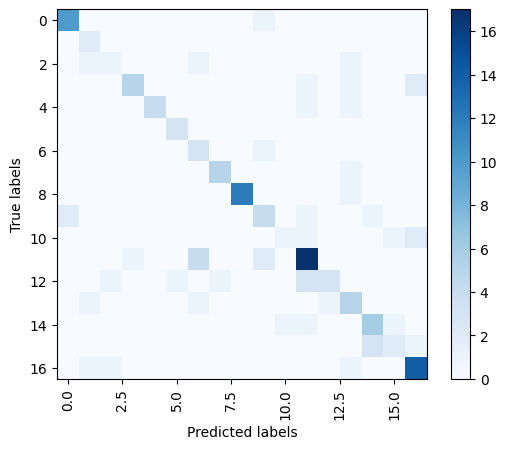

In [ ]:
# Assuming 'clf' is your trained classifier, and 'X_test', 'y_test' are your test data
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix using matplotlib
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.xticks(rotation='vertical')  # Set the rotation of x-tick labels
plt.show()

We want to see brighter colours along the left to right diagonal, because that will tell us more samples are being predicted correctly for each class.

If we see a brighter colour outside of the left to right diagonal, that tells us a specific class is being incorrectly predicted as another class frequently. For example, we may see that dark types were predicted as normal types 4 times.

The combination of the evaluation methods described above can help us improve our model. For example, we may see that our model is underperforming for dark type pokemon, so we may want to direct our efforts towards gathering more dark type examples.

Another common strategy is to look at the SKLearn documentation for the model you're using and read over the parameter descriptions to find anything related to your problem. For example, we might look at the [LogisticRegressionCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) documentation and change the `scoring` and `class_weight` to work better for our imbalanced data.

**Final Challenge**: Create a model that predicts whether a pokemon is a fire type, water type, grass type, or none of the above.

In [ ]:
data = pd.read_csv('pokemon_alopez247.csv', index_col='Number')

X = transform_to_numeric(data)
y = data['Type_1'].copy()



In [ ]:
y

Number
1        Grass
2        Grass
3        Grass
4         Fire
5         Fire
        ...   
717       Dark
718     Dragon
719       Rock
720    Psychic
721       Fire
Name: Type_1, Length: 721, dtype: object

In [ ]:
# We can go through our y data and change the labels that arent fire, water, or grass to None 

y[(y != 'Fire') & (y != 'Water') & (y != 'Grass')] = 'none'

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf = make_pipeline(StandardScaler(), LogisticRegressionCV(max_iter=2500))
clf.fit(X_train, y_train)
pred = clf.predict(X_test)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

        Fire       1.00      0.67      0.80         6
       Grass       0.90      0.75      0.82        12
       Water       0.84      0.76      0.80        21
        none       0.91      0.96      0.94       106

    accuracy                           0.90       145
   macro avg       0.91      0.79      0.84       145
weighted avg       0.90      0.90      0.90       145



# References

- https://medium.com/@DataStevenson/logistic-regression-and-pokemon-945e954d84a3
- `pokemon_alopez247.csv` from https://www.kaggle.com/alopez247/pokemon
